# LAB 1: Binary classification and model selection
Authors: 

    Mathurin Massias (mathurin.massias@gmail.com)
    
    Giacomo Meanti  (giacomo.meanti@gmail.com)


 - This lab addresses binary classification and model selection on synthetic data.
 - The aim of the lab is to play with the libraries and to get a practical grasp of what
we have discussed in class.
 - Follow the instructions below.
 
 
**Goal**
This lab is divided in three parts depending of their level of complexity (Beginner,
Intermediate, Advanced). Your goal is to complete entirely, at least, one of the
three parts.

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn import datasets, model_selection

from lab1_utils import *

## Warmup

You will use a regularized least square model for classification on a toy dataset. 
You will explore the differences between training and test error, and how the regularization parameter affects them.

We will use cross-validation to estimate the best values for the parameter.

In many cases we commented with `# TODO` the places in which you should insert some code.

### Data Generation

The `create_random_data` function is used throughout this lab to generate random datasets. If you want to see how it works, look at the lab1_utils.py file in this folder.

In [16]:
X, y = create_random_data(n_samples=100, noise_level=1.3, dataset="linear")
print("%d samples, %d features" % X.shape)

100 samples, 2 features


<Figure size 1296x720 with 0 Axes>

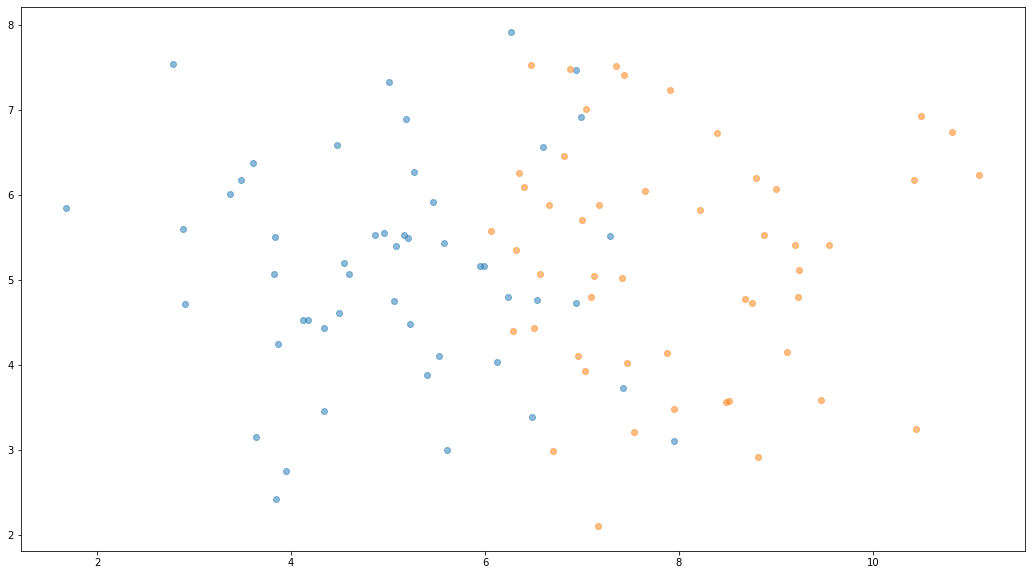

In [18]:
plt.figure(figsize=(18,10))
plot_dataset(X, y)

### Splitting the data into train and test

We use another function defined in the lab1_utils.py file `data_split` to subdivide the data into 80 training samples, and (correspondingly) 20 test samples.

In [21]:
X_train, X_test, y_train, y_test = data_split(X, y, n_train=80)
print("Generated %d training samples, %d test samples" % (X_train.shape[0], X_test.shape[0]))

Generated 80 training samples, 20 test samples


### Training a linear ridge-regression model

We will use the `sklearn.kernel_ridge.KernelRidge` class from scikit-learn to define our models, specifying that we want the "linear" kernel. Then the only parameter is the regularization parameter which we look into in this section.

In [22]:
def binary_classif_error(y_true, y_pred):
    return np.mean(np.sign(y_pred) != y_true)

In [24]:
regularization = 0.1

model = KernelRidge(regularization, kernel="linear")
model.fit(X_train, y_train)

KernelRidge(alpha=0.1)

In [25]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Training error: %.2f%%" % (binary_classif_error(y_train, train_preds) * 100))
print("Test error: %.2f%%" % (binary_classif_error(y_test, test_preds) * 100))

Training error: 25.00%
Test error: 25.00%


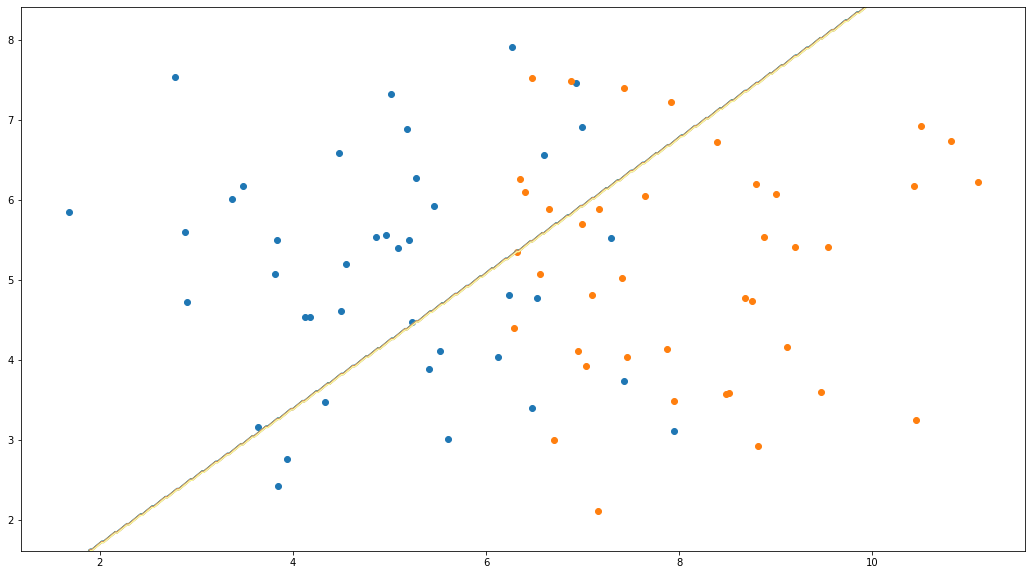

In [27]:
plt.figure(figsize=(18,10))
plot_separation(X_train, y_train, model)
plt.show()

### Exploring the effect of different parameters

First we change the regularization parameter, observing what happens. Since the data is very low-dimensional, the change is not visible until reaching very large amounts of regularization.

For now calculate the test errors (no cross-validation is needed).

In [28]:
# 1. Change the regularization parameter
reg_values = np.geomspace(1e-4, 5e3, num=50)
test_errors = []
for reg in reg_values:
    # TODO: Create the model and compute the test predictions
    model = KernelRidge(alpha=reg, kernel='linear')
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    test_errors.append(binary_classif_error(y_test, test_preds))

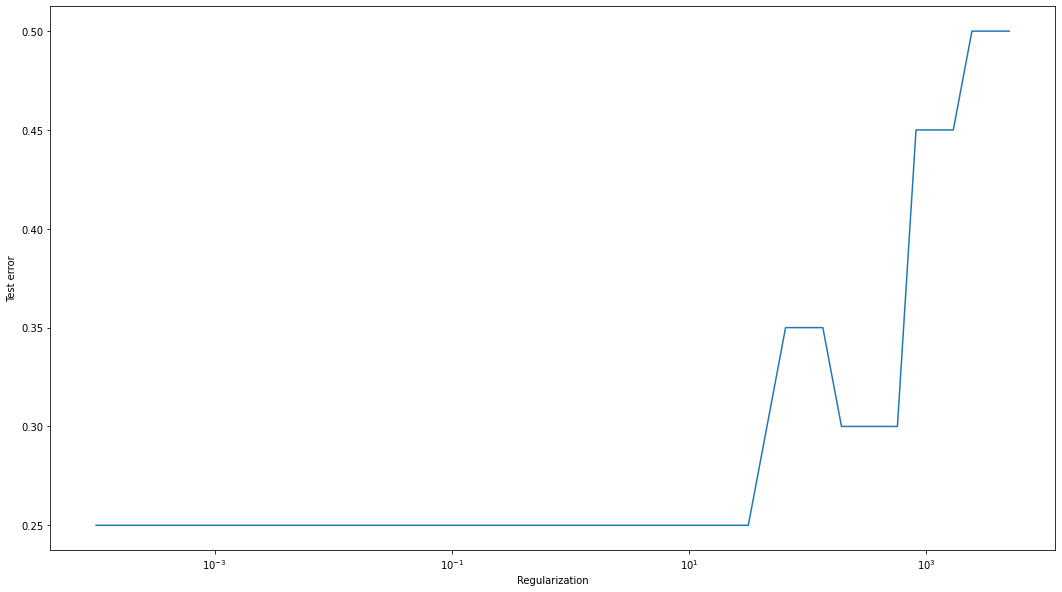

In [30]:
fig, ax = plt.subplots(figsize=(18,10))
ax.semilogx(reg_values, test_errors)
ax.set_xlabel("Regularization")
ax.set_ylabel("Test error");

In [32]:
# 2. Change in number of data-points
num_points = np.arange(5, 1000, 10)
np_test_errors = []
# TODO: Create the model
model = KernelRidge(alpha=0.1, kernel='linear')
for points in num_points:
    X, y = create_random_data(points + 20, 1, seed=932)
    X_train, X_test, y_train, y_test = data_split(X, y, n_train=points)
    # TODO: Fit/Predict
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    np_test_errors.append(binary_classif_error(y_test, test_preds))

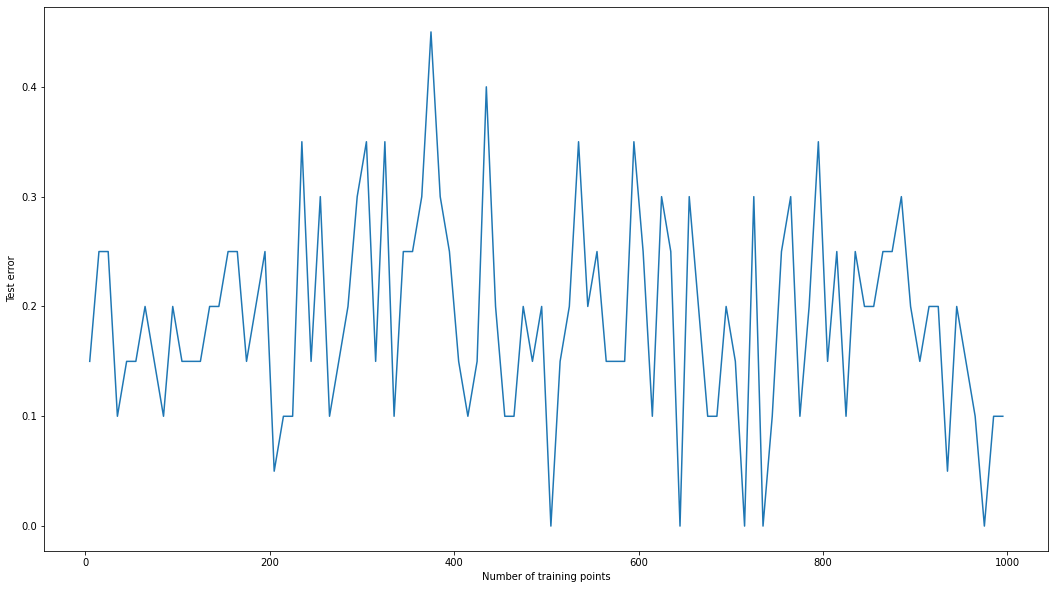

In [33]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(num_points, np_test_errors)
ax.set_xlabel("Number of training points")
ax.set_ylabel("Test error");

In [34]:
# 3. Amount of noise in the data
data_noise = [0.3, 0.5, 1.0, 2.0]
noise_test_errors = []
# TODO: Fill the whole example in
model = KernelRidge(alpha=0.1, kernel='linear')
for noise in data_noise:
    X, y = create_random_data(1000, noise_level=noise, seed=932)
    X_train, X_test, y_train, y_test = data_split(X, y, n_train=800)
    # TODO: Fit/Predict
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    noise_test_errors.append(binary_classif_error(y_test, test_preds))

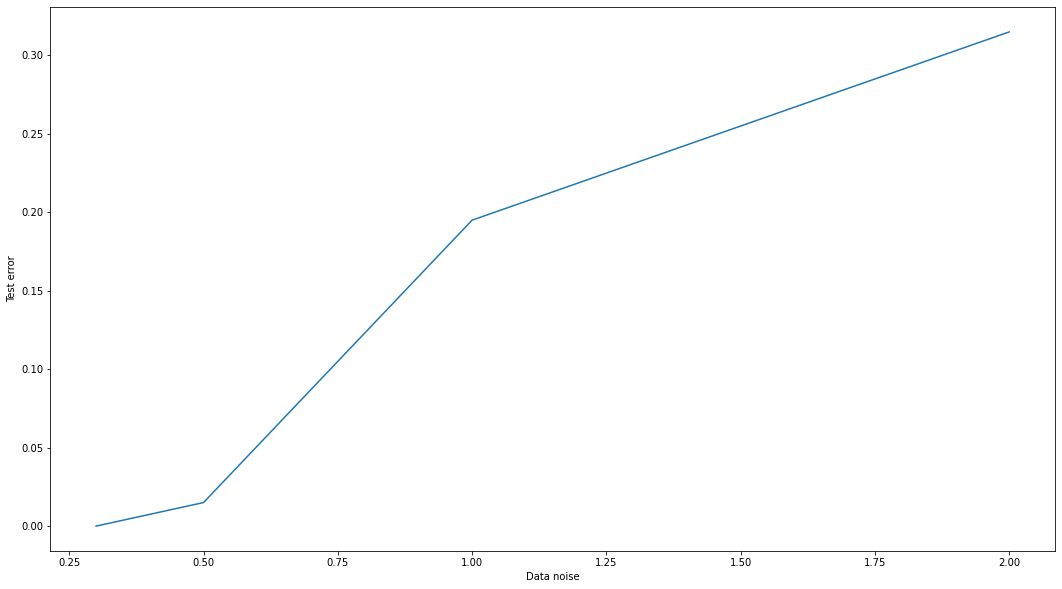

In [35]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(data_noise, noise_test_errors)
ax.set_xlabel("Data noise")
ax.set_ylabel("Test error");

### Cross-Validation

Find the optimal value for the regularization parameter. By using K-fold cross-validation, you can increase the confidence that good parameter settings will still be valid on the test set.

Remember that you should only look at the test set at the very end, to avoid overfitting to it.
In a real-world setting, you will not know what the test data looks like, and relying on cross-validation is one way to reduce overfitting to the training data.

For this exercise it is easy to check different values of the regularization parameter by hand. For more complex scenarios, scikit-learn includes some useful classes which greatly reduce the amount of boilerplate code needed for tuning hyperparameters. For example, look at [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In the case of our data, we have already seen that several regularization parameters seem to work well.
In the following it is sufficient to find one of them.

In [36]:
reg_params = [1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3]
kfold_cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=102)
errors = {rp: [] for rp in reg_params}

X, y = create_random_data(1000, noise_level=0.3, seed=932)
X_train, X_test, y_train, y_test = data_split(X, y, n_train=800)
# Loop through all possible regularization parameters
for rp in reg_params:
    model = KernelRidge(rp, kernel="linear")
    # Run K-Fold CV (on train data)
    for train_index, val_index in kfold_cv.split(X_train):
        # TODO: Fit the model on the training data, and calculate the error on the validation data.
        model.fit(X_train[train_index], y_train[train_index])
        error = binary_classif_error(y_train[val_index], model.predict(X_train[val_index]))
        errors[rp].append(error)

# Calculate the best error and corresponding regularization parameter
min_rp, min_es = min(errors.items(), key=lambda kv: np.mean(kv[1]))
print("The regularization parameter with minimal error is %e" % (min_rp))
print("Achieving a 5-fold CV average error of %.2f%%" % (np.mean(min_es)*100))    

The regularization parameter with minimal error is 1.000000e-07
Achieving a 5-fold CV average error of 0.25%


## Part 2: Kernel ridge regression

Here we will use the same model as in Part 1, but instead of taking the linear kernel, which is equivalent to performing linear ridge regression, we take a different kernel.

Different kernels can have different parameters. For example, the Gaussian (or RBF) kernel is defined by its length-scale, or `sigma`.

To use the Gaussian kernel with the `KernelRidge` estimator, pass `kernel="rbf"` to it instead of `kernel="linear"`.
Note that in scikit-learn, the Gaussian kernel has a `gamma` parameter which is defined as $\gamma = \dfrac{1}{2\sigma^2}$. So be careful that a large $\gamma$ corresponds to small $\sigma$ and viceversa.

### Tasks:
 1. Perform parameter tuning for kernel ridge regression with a Gaussian kernel:
     - Try different (`gamma`, `regularization`) pairs and compare the obtained training and test errors
     - Fix the regularization and observe the effect of changing the length-scale `gamma`
     - Fix `gamma` and observe the effect of changing the regularization
     - Do you notice (and if so, when) any overfitting/oversmoothing effects?
    Try to confirm your results by exploring a range of parameters and plotting the training and test errors.
    
 2. Consider the Polynomial kernel now (can be selected with `kernel="polynomial"`) and perform parameter tuning over its parameters. Note that the polynomial kernel has three different parameters (`gamma`, `degree`, and `coef0`).
     Compare the performances of the polynomial and Gaussian kernels on the *circles* and *moons* datasets with respect to the training set size (e.g. `[10, 20, 50, 100, 1000]`) and the amount of regularization (e.g. `[0.5, 0.1, 0.01, 0.001, 0.0001]`).

#### Generate circles data

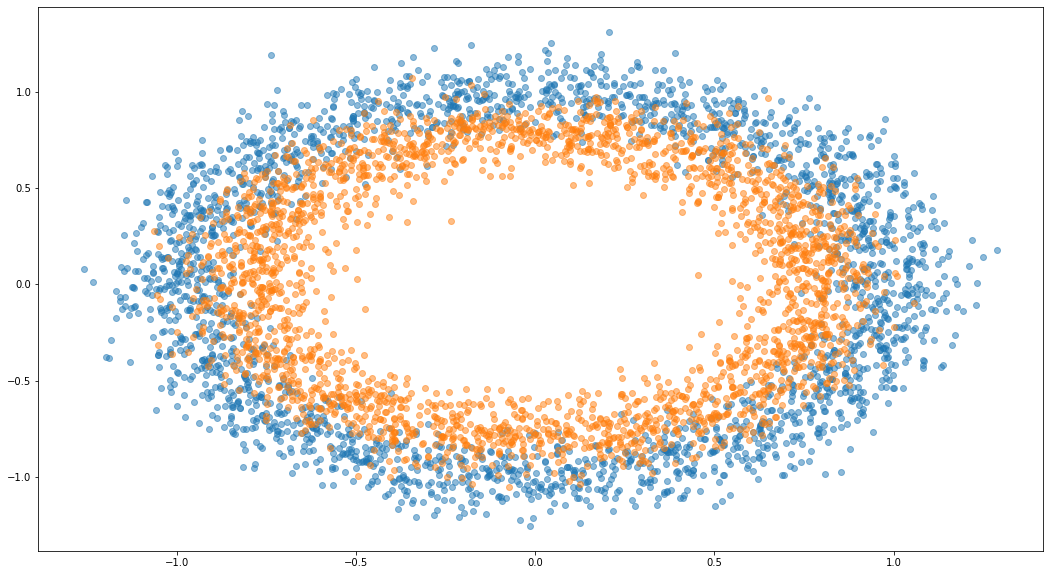

In [37]:
X, y = create_random_data(n_samples=5000, noise_level=0.1, dataset="circles", seed=932)
plot_dataset(X, y)

#### Set-up KRR with Gaussian kernel example

In [38]:
X_train, X_test, y_train, y_test = data_split(X, y, n_train=4000)

In [39]:
g_model = KernelRidge(0.01, kernel="rbf", gamma=0.01)
g_model.fit(X_train, y_train)
g_err = binary_classif_error(y_test, g_model.predict(X_test))
print("Test error of Gaussian kernel with gamma=%.2f, regularization=%.2f : %.2f%%" %
     (g_model.gamma, g_model.alpha, g_err * 100))

Test error of Gaussian kernel with gamma=0.01, regularization=0.01 : 13.80%


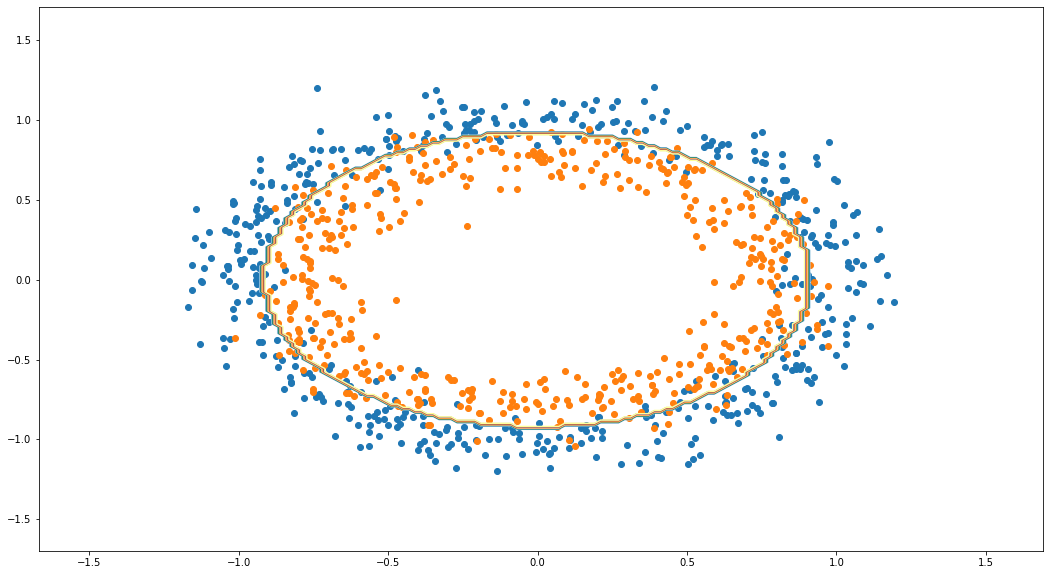

In [40]:
plt.figure(figsize=(18,10))
plot_separation(X_test, y_test, g_model)

#### Find the best parameter values

In [41]:
#TODO
param_grid = {
    "alpha": [0.001, 0.1, 0.1, 1.0, 10, 100, 1000], # TODO: Insert some values to test
    "gamma": [0.001, 0.1, 0.1, 1.0, 10, 100, 1000] # TODO: Insert some values to test
}
g_model = KernelRidge(kernel="rbf")

g_modelGSCV = model_selection.GridSearchCV(g_model, param_grid)
g_modelGSCV.fit(X_train, y_train)
print(g_modelGSCV.best_params_)

{'alpha': 1.0, 'gamma': 10}


#### Does the Gaussian kernel overfit? If so, for which parameters?

In [42]:
from sklearn.model_selection import validation_curve

In [43]:
#TODO
g_model = KernelRidge(alpha=1.0, kernel="rbf")
train_score, validation_score = validation_curve(g_model, X=X_train, y=y_train, param_name="gamma", param_range=[0.001, 0.01, 0.1, 1.0, 10, 100, 1000], cv=10)
train_mean= np.mean(train_score, axis=1)
validation_mean = np.mean(validation_score, axis=1)

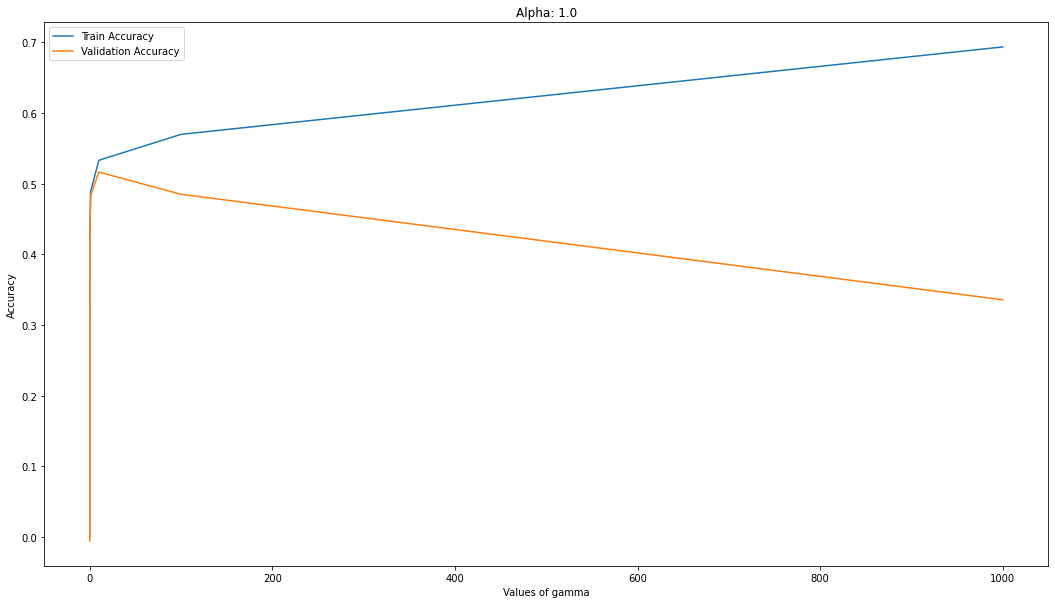

In [44]:
plt.figure(figsize=(18,10))
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], train_mean)
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], validation_mean)
plt.title("Alpha: 1.0")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Values of gamma")
plt.ylabel("Accuracy")
plt.show()

In [45]:
#TODO
g_model = KernelRidge(gamma=10, kernel="rbf")
train_score, validation_score = validation_curve(g_model, X=X_train, y=y_train, param_name="alpha", param_range=[0.001, 0.01, 0.1, 1.0, 10, 100, 1000], cv=10)
train_mean= np.mean(train_score, axis=1)
validation_mean = np.mean(validation_score, axis=1)

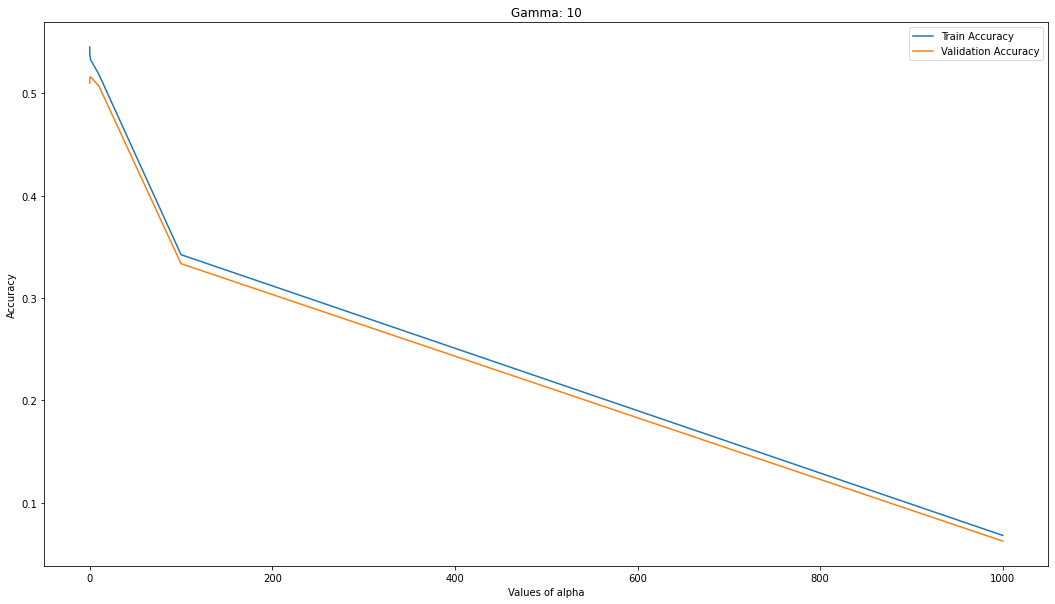

In [46]:
plt.figure(figsize=(18,10))
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], train_mean)
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], validation_mean)
plt.title("Gamma: 10")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Values of alpha")
plt.ylabel("Accuracy")
plt.show()

Yes, the gaussian kernel overfits for values of gamma greater than 10.

#### Compare Gaussian and Polynomial kernels on the circles and moons datasets

Since the Polynomial kernel has many parameters, you can perform a full grid search to understand how these parameters interact. We have provided you with a skeleton code for the grid search.

In [47]:
param_grid = {
    "coef0": [0, 1], # TODO: Insert some values to test
    "degree": [2, 3, 4], # TODO: Insert some values to test
    "gamma": [0.01, 1, 10] # TODO: Insert some values to test
}
model = KernelRidge(1.0, kernel="polynomial")
gs = model_selection.GridSearchCV(model, param_grid)#, scoring="accuracy")

In [48]:
# TODO! Fit the Grid Search
gs.fit(X_train, y_train)

GridSearchCV(estimator=KernelRidge(alpha=1.0, kernel='polynomial'),
             param_grid={'coef0': [0, 1], 'degree': [2, 3, 4],
                         'gamma': [0.01, 1, 10]})

In [49]:
# TODO: Have a look at the results (hint: look at the cv_results_ attribute)
import pandas as pd
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coef0,param_degree,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.423517,0.026701,0.014000,1.672943e-03,0,2,0.01,"{'coef0': 0, 'degree': 2, 'gamma': 0.01}",0.007827,7.911923e-03,-0.000442,0.000932,0.004261,0.004098,0.003438,13
1,0.455208,0.006454,0.011400,4.890258e-04,0,2,1,"{'coef0': 0, 'degree': 2, 'gamma': 1}",0.044790,3.985726e-02,0.004719,0.011393,0.057303,0.031612,0.020168,10
2,0.471103,0.014166,0.013000,2.367046e-03,0,2,10,"{'coef0': 0, 'degree': 2, 'gamma': 10}",0.044796,3.985936e-02,0.004693,0.011372,0.057328,0.031610,0.020186,11
3,0.771708,0.047262,0.123606,7.862986e-03,0,3,0.01,"{'coef0': 0, 'degree': 3, 'gamma': 0.01}",-0.000629,-7.853550e-07,-0.005657,-0.004924,-0.005658,-0.003374,0.002520,16
4,0.772396,0.020953,0.116399,4.964221e-03,0,3,1,"{'coef0': 0, 'degree': 3, 'gamma': 1}",-0.006083,-2.370845e-03,-0.006712,-0.004891,-0.006949,-0.005401,0.001675,17
5,0.787200,0.031865,0.118199,8.109214e-03,0,3,10,"{'coef0': 0, 'degree': 3, 'gamma': 10}",-0.006094,-2.379104e-03,-0.006715,-0.004892,-0.006952,-0.005406,0.001674,18
6,0.778400,0.029104,0.128400,7.838960e-03,0,4,0.01,"{'coef0': 0, 'degree': 4, 'gamma': 0.01}",-0.000623,2.112159e-06,-0.005655,-0.004922,-0.005654,-0.003371,0.002521,15
7,0.764346,0.015746,0.117600,4.629703e-03,0,4,1,"{'coef0': 0, 'degree': 4, 'gamma': 1}",0.123807,1.122896e-01,0.068319,0.079733,0.143733,0.105576,0.027890,7
8,0.781419,0.027262,0.112400,7.995251e-04,0,4,10,"{'coef0': 0, 'degree': 4, 'gamma': 10}",0.123811,1.122915e-01,0.068274,0.079704,0.143769,0.105570,0.027918,8
9,0.448713,0.009569,0.012800,1.720573e-03,1,2,0.01,"{'coef0': 1, 'degree': 2, 'gamma': 0.01}",0.005266,8.813653e-03,0.001798,0.004136,-0.002703,0.003462,0.003824,14


In [50]:
# Evaluate results
print("Best estimator: ", gs.best_estimator_)
gs.best_estimator_.fit(X_train, y_train)
test_preds = gs.best_estimator_.predict(X_test)
print("Test error: %.2f" % (binary_classif_error(y_test, test_preds)))

Best estimator:  KernelRidge(alpha=1.0, degree=4, gamma=10, kernel='polynomial')
Test error: 0.14


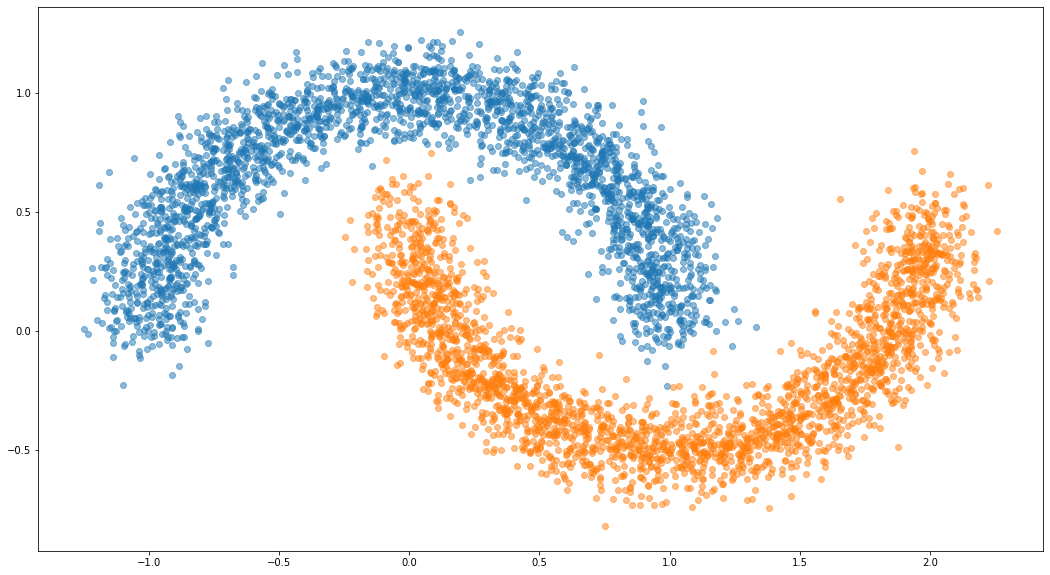

In [52]:
# TODO: Run the same for the moons dataset

X, y = create_random_data(n_samples=5000, noise_level=0.1, dataset="moons", seed=932)
plot_dataset(X, y)

In [53]:
X_train, X_test, y_train, y_test = data_split(X, y, n_train=4000)

In [54]:
g_model = KernelRidge(0.01, kernel="rbf", gamma=0.01)
g_model.fit(X_train, y_train)
g_err = binary_classif_error(y_test, g_model.predict(X_test))
print("Test error of Gaussian kernel with gamma=%.2f, regularization=%.2f : %.2f%%" %
     (g_model.gamma, g_model.alpha, g_err * 100))

Test error of Gaussian kernel with gamma=0.01, regularization=0.01 : 9.20%


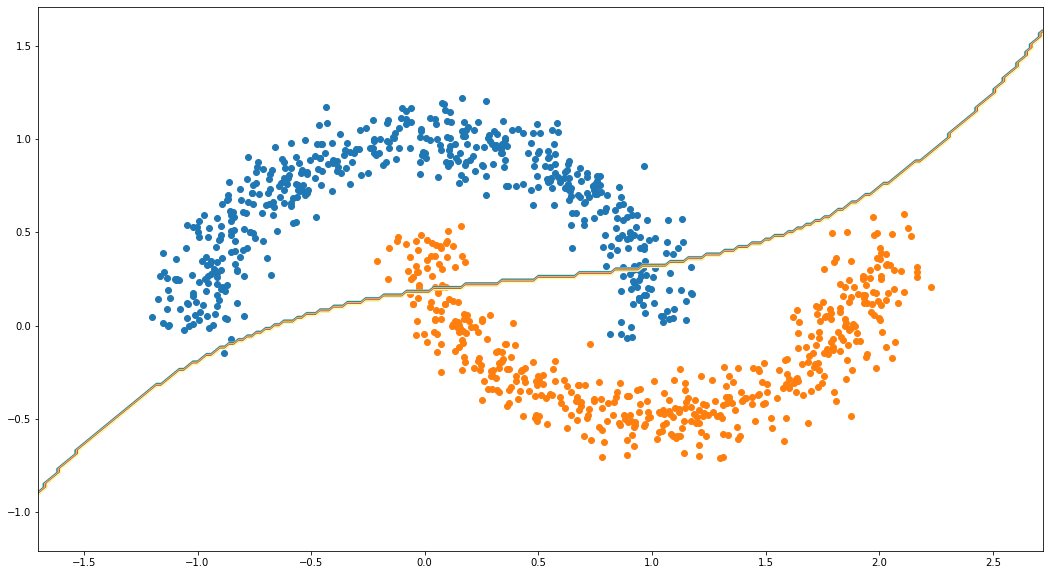

In [55]:
plt.figure(figsize=(18,10))
plot_separation(X_test, y_test, g_model)

In [56]:
param_grid = {
    "alpha": [0.001, 0.1, 0.1, 1.0, 10, 100, 1000], # TODO: Insert some values to test
    "gamma": [0.001, 0.1, 0.1, 1.0, 10, 100, 1000] # TODO: Insert some values to test
}
g_model = KernelRidge(kernel="rbf")

g_modelGSCV = model_selection.GridSearchCV(g_model, param_grid)
g_modelGSCV.fit(X_train, y_train)
print(g_modelGSCV.best_params_)

{'alpha': 0.001, 'gamma': 10}


In [57]:
from sklearn.model_selection import validation_curve

In [58]:
g_model = KernelRidge(alpha=0.001, kernel="rbf")
train_score, validation_score = validation_curve(g_model, X=X_train, y=y_train, param_name="gamma", param_range=[0.001, 0.01, 0.1, 1.0, 10, 100, 1000], cv=10)
train_mean= np.mean(train_score, axis=1)
validation_mean = np.mean(validation_score, axis=1)

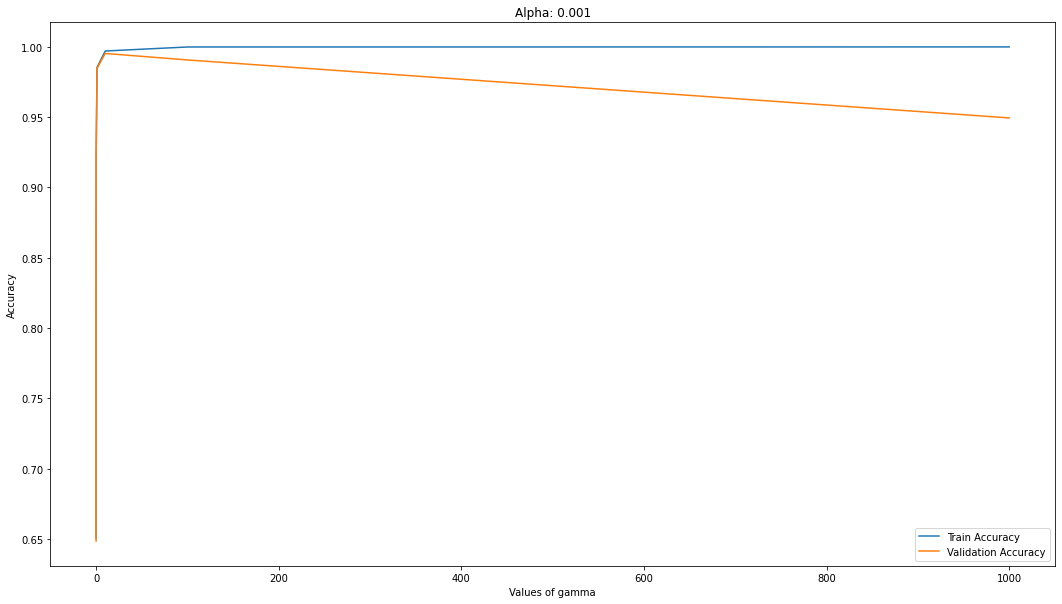

In [59]:
plt.figure(figsize=(18,10))
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], train_mean)
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], validation_mean)
plt.title("Alpha: 0.001")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Values of gamma")
plt.ylabel("Accuracy")
plt.show()

In [60]:
g_model = KernelRidge(gamma=10, kernel="rbf")
train_score, validation_score = validation_curve(g_model, X=X_train, y=y_train, param_name="alpha", param_range=[0.001, 0.01, 0.1, 1.0, 10, 100, 1000], cv=10)
train_mean= np.mean(train_score, axis=1)
validation_mean = np.mean(validation_score, axis=1)

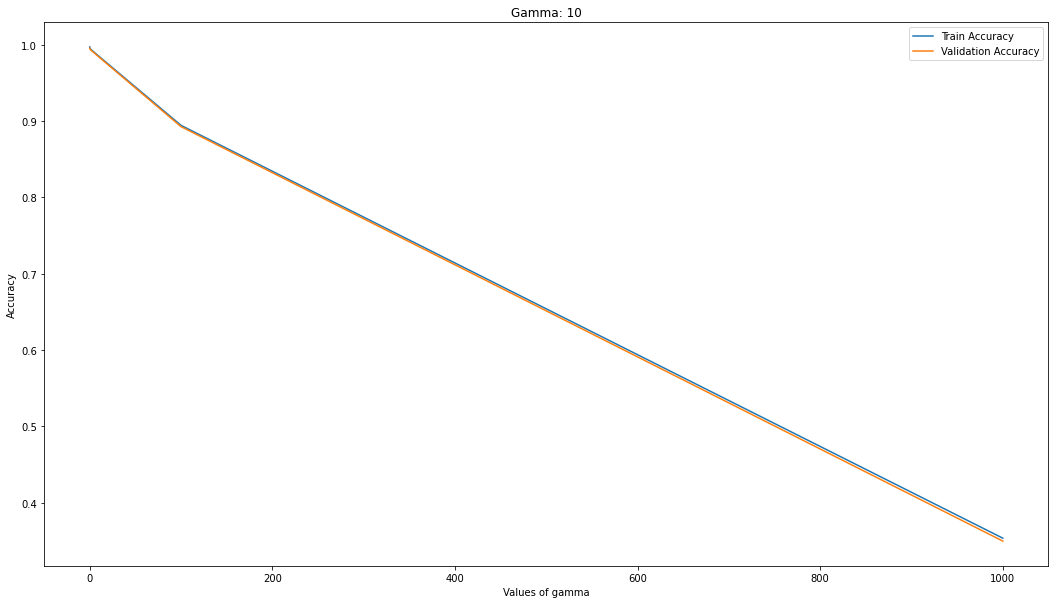

In [61]:
plt.figure(figsize=(18,10))
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], train_mean)
plt.plot([0.001, 0.01, 0.1, 1.0, 10, 100, 1000], validation_mean)
plt.title("Gamma: 10")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Values of gamma")
plt.ylabel("Accuracy")
plt.show()

In [68]:
g_model = KernelRidge(0.01, kernel="rbf", gamma=0.1)
g_model.fit(X_train, y_train)
g_err = binary_classif_error(y_test, g_model.predict(X_test))
print("Test error of Gaussian kernel with gamma=%.2f, regularization=%.2f : %.2f%%" %
     (g_model.gamma, g_model.alpha, g_err * 100))

Test error of Gaussian kernel with gamma=0.10, regularization=0.01 : 0.60%


In [69]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=np.sign(g_model.predict(X_test)))

0.994

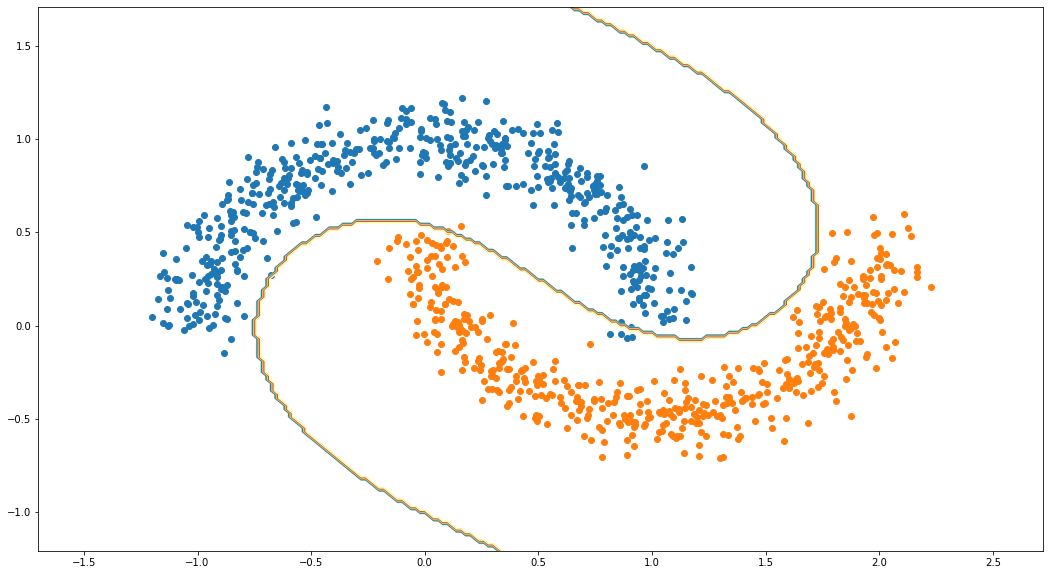

In [70]:
plt.figure(figsize=(18,10))
plot_separation(X_test, y_test, g_model)

In [71]:
g_model = KernelRidge(0.01, kernel="polynomial", gamma=0.1)
g_model.fit(X_train, y_train)
g_err = binary_classif_error(y_test, g_model.predict(X_test))
print("Test error of Gaussian kernel with gamma=%.2f, regularization=%.2f : %.2f%%" %
     (g_model.gamma, g_model.alpha, g_err * 100))

Test error of Gaussian kernel with gamma=0.10, regularization=0.01 : 0.90%


In [72]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=np.sign(g_model.predict(X_test)))

0.991

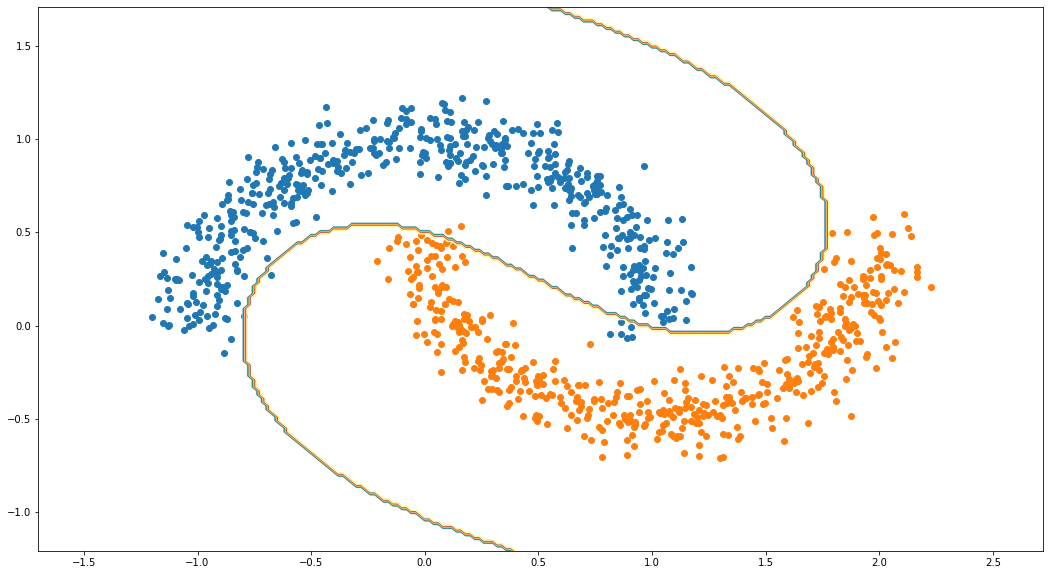

In [65]:
plt.figure(figsize=(18,10))
plot_separation(X_test, y_test, g_model)

## Part 3: Challenge

The challenge consists in a learning task using a real dataset, namely **USPS (United
States Postal Service)**: This dataset contains a number of handwritten digits images. 
The problem is to train *the best KR classifier* that is able to discriminate between the digits *1* and *7*.

The data should be in the git repository ('challenge_datasets' folder, please see the `load_challenge` function).

Once the classifiers are trained, they must be exported by means of the `save_challenge` function.

**Submission:** You should upload your results, as generated by the `save_challenge` function  to the link:
https://www.dropbox.com/request/K4vX1jIOGiX8hks6mtJF by the end of the challenge session.
The results will be presented during the next class. The score of your result
will be based on the accuracy of the classifier on a completely independently
sampled test set.

**Deadline:** 6 PM


In [ ]:
def load_challenge():
    """Loads the USPS one and seven digits.
    """
    one = loadmat("../../data/one_train.mat")["one_train"]
    seven = loadmat("../../data/seven_train.mat")["seven_train"]
    X = np.concatenate((one, seven), 0)
    Y = np.ones((X.shape[0], ))
    Y[one.shape[0]: ] = -1
    return X, Y

def save_challenge(name, regularization, kernel, kernel_parameters, train_err):
    """Save your solution to a file.
    
    Parameters
    ----------
    name
        A string in `name-surname` format (e.g. "giacomo-meanti")
    regularization
        The amount of regularization used
    kernel
        A string representing the kernel you used (this can be "linear", "gaussian", "polynomial")
    kernel_parameters
        A tuple containing the parameters of your kernel. For linear kernels this will be the empty
        tuple `()`; for the gaussian kernel it will contain one parameter for gamma, and for the
        polynomial kernel it should contain three parameters: gamma, degree and coef0
    train_err
        The binary classification error obtained on the data provided.
    """
    if not isinstance(name, str):
        raise ValueError("Name (%s) must be a string" % (name))
    try:
        regularization = float(regularization)
    except TypeError:
        raise ValueError("regularization (%s) must be a numeric value" % (regularization))
    if not isinstance(kernel, str):
        raise ValueError("kernel (%s) must be a string" % (kernel))
    try:
        train_err = float(train_err)
    except TypeError:
        raise ValueError("train_err (%s) must be a numeric value" % (train_err))
    
    
    save_struct = {
        "name": name,
        "regularization": regularization,
        "kernel": kernel,
        "kernel_parameters": kernel_parameters,
        "train_err": train_err
    }
    out_file_name = "%s.pkl" % (name)
    with open(out_file_name, "wb") as out_file:
        pickle.dump(save_struct, out_file)
    print("%s you learned with success!\n\nyour learned model uses %s kernel, "
          "kernel parameters %s and regularization parameter %f. \n\n"
          "Its error is %2.2f%% \n\n"
          "AND REMEMBER: if you like it submit your solution!!" % 
          (name, kernel, kernel_parameters, regularization, train_err*100))
    print("\nThe solution file was saved to '%s'" % (out_file_name))

We provide an example below of how to load the data, run a simple linear classifier, and save the results to a file. 

In [ ]:
X, y = load_challenge()
X.shape, y.shape

In [ ]:
regularization = 200

k = KernelRidge(regularization, kernel="linear")
k.fit(X, y)
err = binary_classif_error(y, k.predict(X))
print("error: ", err)

In [ ]:
name = "" # TODO: INSERT YOUR NAME-SURNAME (e.g. "giacomo-meanti")
save_challenge(name,
               regularization=regularization, kernel="linear",
               kernel_parameters=(), train_err=err)

In [ ]:
# TODO: Write your own model!